[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/trim-filter-messages.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239435-lesson-4-trim-and-filter-messages)

# Filtering and trimming messages

## Review

Now, we have a deeper understanding of a few things: 

* How to customize the graph state schema
* How to define custom state reducers
* How to use multiple graph state schemas

## Goals

Now, we can start using these concepts with models in LangGraph!
 
In the next few sessions, we'll build towards a chatbot that has long-term memory.

Because our chatbot will use messages, let's first talk a bit more about advanced ways to work with messages in graph state.

In [23]:
# %%capture --no-stderr
# %pip install --quiet -U langchain_core langgraph langchain_openai

In [24]:
# import os, getpass

# def _set_env(var: str):
#     if not os.environ.get(var):
#         os.environ[var] = getpass.getpass(f"{var}: ")

# _set_env("OPENAI_API_KEY")

In [25]:
import os
from dotenv import load_dotenv


load_dotenv("../.env")

True

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

We'll log to a project, `langchain-academy`. 

In [26]:
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

## Messages as state

First, let's define some messages.

In [27]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


Recall we can pass them to a chat model.

In [28]:
from langchain_openai import ChatOpenAI
from langchain_ollama import ChatOllama


# llm = ChatOpenAI(model="gpt-4o")
llm = ChatOllama(model="llama3.2:1b")
llm.invoke(messages)

AIMessage(content="There are many fascinating ocean mammals beyond whales. Here are some interesting ones to consider learning about:\n\n1. **Dolphins**: Intelligent and social marine mammals known for their playful behavior and advanced communication skills.\n2. **Seals and Sea Lions**: Euxine seals (sea lions) are closely related to pinnipeds, while Weddell seals and Crabeater seals are members of the odontoceti clade. They're often found in Antarctica and the southern hemisphere's coastlines.\n3. **Walruses**: Large, carnivorous mammals with distinctive tusks, walruses live in Arctic and sub-Arctic waters.\n4. **Manatees**: Also known as sea cows, manatees are gentle giants that inhabit warm, shallow waters in the Caribbean and Gulf of Mexico.\n5. **Sperm Whales**: The largest animal on Earth, sperm whales have a distinctive black-and-white coloration and are known for their massive heads.\n6. **Pilot Whales**: Small, melon-headed cetaceans found in tropical and temperate oceans, pi

We can run our chat model in a simple graph with `MessagesState`.

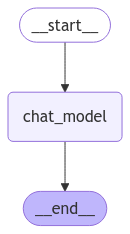

In [29]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END


# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [30]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

There are so many fascinating ocean creatures beyond whales. Here are some lesser-known but equally interesting ones:

1. **Dolphins**: Like whales, dolphins are highly intelligent and social marine mammals. They're known for their playful antics and sophisticated communication skills.
2. **Seals and Sea Lions**: These pinnipeds (fin-footed mammals) are found in coastal waters around the world. They're agile swimmers and can be quite mischievous when they're not hunting.
3. **Squid and Octopuses**: These cephalopods are some of the most intelligent invertebrates on the planet. Their massive eyes, suckers, and cam

## Reducer

A practical challenge when working with messages is managing long-running conversations. 

Long-running conversations result in high token usage and latency if we are not careful, because we pass a growing list of messages to the model.

We have a few ways to address this.

First, recall the trick we saw using `RemoveMessage` and the `add_messages` reducer.

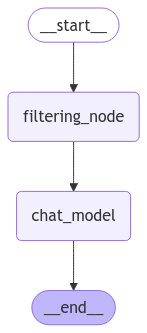

In [31]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {
        "messages": delete_messages
    }

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filtering_node", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filtering_node")
builder.add_edge("filtering_node", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [32]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

There are so many fascinating ocean creatures beyond whales. Here are some interesting ones to get you started:

1. **Dolphins**: Like whales, dolphins are highly intelligent and social marine mammals. They're known for their playful behavior and acrobatic feats.
2. **Seals and Sea Lions**: These pinnipeds (fin-footed mammals) are excellent swimmers and can be found in both warm and cold waters around the world.
3. **Squids and Octopuses**: These cephalopods are masters of disguise and have incredible intelligence. They have a unique body structure that allows them to change color and shape.
4. **Fish**: With ove

## Filtering messages

If you don't need or want to modify the graph state, you can just filter the messages you pass to the chat model.

For example, just pass in a filtered list: `llm.invoke(messages[-1:])` to the model.

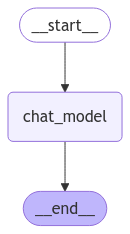

In [33]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Let's take our existing list of messages, append the above LLM response, and append a follow-up question.

In [34]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about polar bears!", name="Mert"))

In [35]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

There are so many fascinating ocean creatures beyond whales. Here are some interesting ones to get you started:

1. **Dolphins**: Like whales, dolphins are highly intelligent and social marine mammals. They're known for their playful behavior and acrobatic feats.
2. **Seals and Sea Lions**: These pinnipeds (fin-footed mammals) are excellent swimmers and can be found in both warm and cold waters around the world.
3. **Squid

In [36]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

There are so many fascinating ocean creatures beyond whales. Here are some interesting ones to get you started:

1. **Dolphins**: Like whales, dolphins are highly intelligent and social marine mammals. They're known for their playful behavior and acrobatic feats.
2. **Seals and Sea Lions**: These pinnipeds (fin-footed mammals) are excellent swimmers and can be found in both warm and cold waters around the world.
3. **Squid

The state has all of the mesages.

But, let's look at the LangSmith trace to see that the model invocation only uses the last message:

https://smith.langchain.com/public/75aca3ce-ef19-4b92-94be-0178c7a660d9/r

## Trim messages

Another approach is to [trim messages](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens), based upon a set number of tokens. 

This restricts the message history to a specified number of tokens.

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

See the `trim_messages` below.

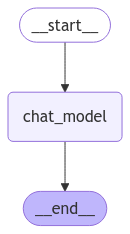

In [37]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            # token_counter=ChatOpenAI(model="gpt-4o"),
            token_counter=ChatOllama(model="llama3.2:1b"),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [38]:
messages.append(output['messages'][-1])
messages.append(
    HumanMessage(
        f"By the way, where was the capital city of the United Kingdom again?",
        name="Mert"
    )
)

In [39]:
messages

[AIMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Bot', id='1'),
 HumanMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Lance', id='2'),
 AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
 HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='4'),
 AIMessage(content="There are so many fascinating ocean creatures beyond whales. Here are some interesting ones to get you started:\n\n1. **Dolphins**: Like whales, dolphins are highly intelligent and social marine mammals. They're known for their playful behavior and acrobatic feats.\n2. **Seals and Sea Lions**: These pinnipeds (fin-footed mammals) are excellent swimmers and can be found in both warm and cold waters around the world.\n3. **Squids and Octopuses**: These cephalopods are masters of disguise and have in

In [40]:
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=100,
            strategy="last",
            # token_counter=ChatOpenAI(model="gpt-4o"),
            token_counter=ChatOllama(model="llama3.2:1b"),
            allow_partial=False
        )

[HumanMessage(content='By the way, where was the capital city of the United Kingdom again?', additional_kwargs={}, response_metadata={}, name='Mert')]

In [41]:
# Invoke, using message trimming in the chat_model_node 
messages_out_trim = graph.invoke({'messages': messages})

In [42]:
messages_out_trim

{'messages': [AIMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Bot', id='1'),
  HumanMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Lance', id='2'),
  AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
  HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='4'),
  AIMessage(content="There are so many fascinating ocean creatures beyond whales. Here are some interesting ones to get you started:\n\n1. **Dolphins**: Like whales, dolphins are highly intelligent and social marine mammals. They're known for their playful behavior and acrobatic feats.\n2. **Seals and Sea Lions**: These pinnipeds (fin-footed mammals) are excellent swimmers and can be found in both warm and cold waters around the world.\n3. **Squids and Octopuses**: These cephalopods are masters of dis

Let's look at the LangSmith trace to see the model invocation:

https://smith.langchain.com/public/b153f7e9-f1a5-4d60-8074-f0d7ab5b42ef/r